<a href="https://colab.research.google.com/github/sagawritescode/ERA-V1/blob/main/ERA_V1_Assignment_8_Batch_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [12]:
%matplotlib inline

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms

Data Download and Transformations

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Inspect the dataset

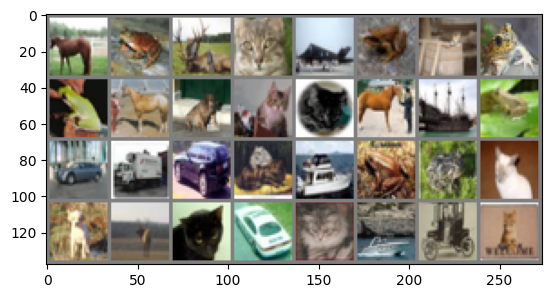

horse frog  deer  cat   plane frog  cat   frog  frog  horse dog   cat   cat   horse ship  frog  car   truck car   cat   ship  frog  frog  cat   dog   deer  cat   car   cat   ship  car   cat  


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Model Initialisation and Summary

In [16]:
!pip install torchsummary
from torchsummary import summary
from model import BatchNormalisationModel
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = BatchNormalisationModel().to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 34, 34]             512
        MaxPool2d-10           [-1, 16, 17, 17]               0
           Conv2d-11           [-1, 16, 17, 17]           2,304
             ReLU-12           [-1, 16, 17, 17]               0

Define Train and Test Functions

In [17]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassified_images = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    iterator_count = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_comparisons = pred.eq(target.view_as(pred))
            correct += pred_comparisons.sum().item()

            ## code to store misclassfied images
            predictions = pred_comparisons.squeeze()
            pred = pred.squeeze()
            target = (target.view_as(pred)).squeeze()
            index = 0
            if len(misclassified_images) < 10:
                for prediction in predictions:
                    if prediction.item() is False:

                        misclassified_images.append((data[index], pred[index].item(), target[index].item()))
                        break
                    index += 1

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

Learning (And Simultaneous Evaluation) Begins!

In [18]:
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.0926381349563599 Batch_id=1562 Accuracy=43.86: 100%|██████████| 1563/1563 [00:17<00:00, 87.27it/s]



Test set: Average loss: 1.2211, Accuracy: 5553/10000 (55.53%)

EPOCH: 1


Loss=0.7075862884521484 Batch_id=1562 Accuracy=58.31: 100%|██████████| 1563/1563 [00:17<00:00, 91.14it/s]



Test set: Average loss: 1.0370, Accuracy: 6279/10000 (62.79%)

EPOCH: 2


Loss=0.8043328523635864 Batch_id=1562 Accuracy=62.94: 100%|██████████| 1563/1563 [00:17<00:00, 91.58it/s]



Test set: Average loss: 0.9627, Accuracy: 6554/10000 (65.54%)

EPOCH: 3


Loss=0.7686347365379333 Batch_id=1562 Accuracy=65.87: 100%|██████████| 1563/1563 [00:16<00:00, 92.10it/s]



Test set: Average loss: 0.9068, Accuracy: 6763/10000 (67.63%)

EPOCH: 4


Loss=1.1605305671691895 Batch_id=1562 Accuracy=67.77: 100%|██████████| 1563/1563 [00:16<00:00, 92.13it/s]



Test set: Average loss: 0.8480, Accuracy: 6975/10000 (69.75%)

EPOCH: 5


Loss=1.0893030166625977 Batch_id=1562 Accuracy=69.76: 100%|██████████| 1563/1563 [00:16<00:00, 92.26it/s]



Test set: Average loss: 0.8207, Accuracy: 7082/10000 (70.82%)

EPOCH: 6


Loss=0.7894973754882812 Batch_id=1562 Accuracy=73.06: 100%|██████████| 1563/1563 [00:17<00:00, 91.80it/s]



Test set: Average loss: 0.7365, Accuracy: 7383/10000 (73.83%)

EPOCH: 7


Loss=0.8663007020950317 Batch_id=1562 Accuracy=73.82: 100%|██████████| 1563/1563 [00:17<00:00, 90.54it/s]



Test set: Average loss: 0.7433, Accuracy: 7377/10000 (73.77%)

EPOCH: 8


Loss=0.49970975518226624 Batch_id=1562 Accuracy=74.43: 100%|██████████| 1563/1563 [00:17<00:00, 90.12it/s]



Test set: Average loss: 0.7340, Accuracy: 7372/10000 (73.72%)

EPOCH: 9


Loss=0.7985553741455078 Batch_id=1562 Accuracy=74.52: 100%|██████████| 1563/1563 [00:17<00:00, 90.88it/s]



Test set: Average loss: 0.7267, Accuracy: 7400/10000 (74.00%)

EPOCH: 10


Loss=0.612556517124176 Batch_id=1562 Accuracy=74.85: 100%|██████████| 1563/1563 [00:17<00:00, 91.26it/s]



Test set: Average loss: 0.7211, Accuracy: 7447/10000 (74.47%)

EPOCH: 11


Loss=0.5350287556648254 Batch_id=1562 Accuracy=74.79: 100%|██████████| 1563/1563 [00:17<00:00, 90.06it/s]



Test set: Average loss: 0.7362, Accuracy: 7408/10000 (74.08%)

EPOCH: 12


Loss=0.8082892894744873 Batch_id=1562 Accuracy=75.43: 100%|██████████| 1563/1563 [00:17<00:00, 89.81it/s]



Test set: Average loss: 0.7103, Accuracy: 7474/10000 (74.74%)

EPOCH: 13


Loss=0.641403079032898 Batch_id=1562 Accuracy=75.70: 100%|██████████| 1563/1563 [00:17<00:00, 91.15it/s]



Test set: Average loss: 0.7242, Accuracy: 7419/10000 (74.19%)

EPOCH: 14


Loss=0.4658927023410797 Batch_id=1562 Accuracy=75.73: 100%|██████████| 1563/1563 [00:16<00:00, 93.50it/s]



Test set: Average loss: 0.7298, Accuracy: 7416/10000 (74.16%)



Display misclassified images

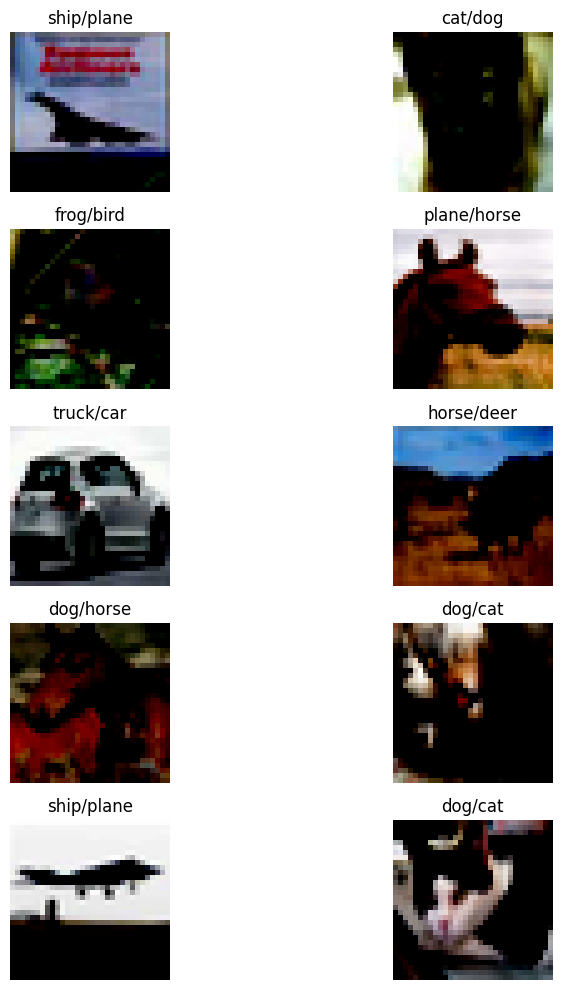

In [19]:
def denormalise_image(normalized_image):
    denormalize = transforms.Normalize((-1, -1, -1), (2, 2, 2))

    # Denormalize the image
    denormalized_image = denormalize(normalized_image)

    # Convert the tensor to a numpy array
    denormalized_image = denormalized_image.cpu().numpy()

    # Convert the image from range [-1, 1] to [0, 1]
    denormalized_image = (denormalized_image + 1) / 2

    return denormalized_image

denormalised_images = []
for image, pred, target in misclassified_images:
    denormalised_images.append((denormalise_image(image), pred, target))


fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for i in range(5):
    for j in range(2):
        misclassified_image = misclassified_images[i * 2 + j]
        image = misclassified_image[0].cpu().numpy()
        axes[i, j].imshow(np.transpose(image, (1, 2, 0)))
        axes[i, j].axis('off')

        axes[i, j].set_title(f'{classes[misclassified_image[1]]}/{classes[misclassified_image[2]]}')
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

<class 'numpy.ndarray'>


Text(0.5, 1.0, 'Test Accuracy')

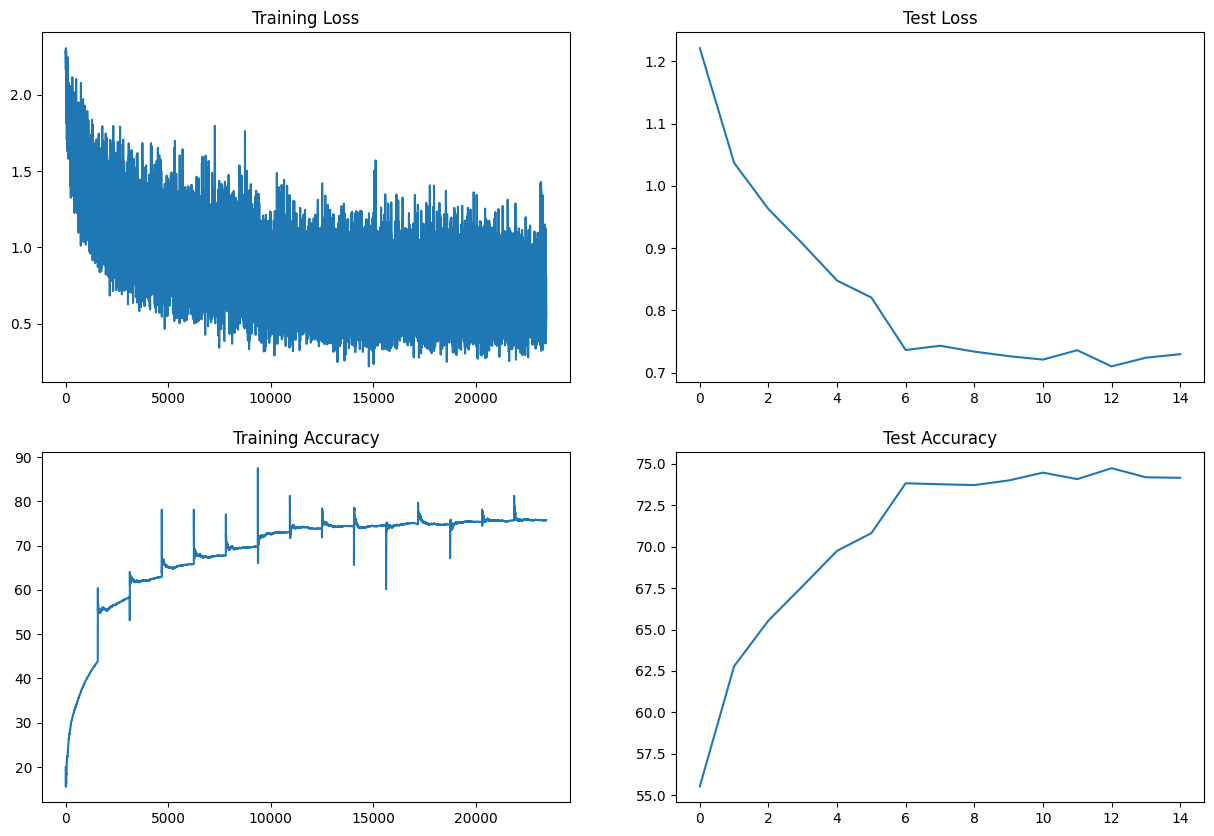

In [27]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
print(type(axs))
t = [t_items.item() for t_items in train_losses]
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")